In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

['/device:CPU:0', '/device:GPU:0']


## Data : cifar 10

In [3]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(X_tot, y_tot), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=10)
y_tot=to_categorical(y_tot, num_classes=10)

print(X_tot.shape)
print(y_tot.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [4]:
#shuffle data and split data to generate validation data
shuffler = np.random.RandomState(seed=42).permutation(len(X_tot))
X_tot = X_tot[shuffler]
y_tot = y_tot[shuffler]
 
#validation data
X_val=X_tot[0:2000]
y_val=y_tot[0:2000]

X_train=X_tot[2000:]
y_train=y_tot[2000:]

In [5]:
def train(model,path):
    train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            width_shift_range=4, #+-8 pixel shift max
            height_shift_range=4)#+-8 pixel shift max

    reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                                  patience=5, min_lr=0.001, verbose=1)

    #Early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=10)
    # checkpoints
    checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])

    train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
    step_size_train=train_generator.n//train_generator.batch_size

    history=model.fit(train_generator,
                        steps_per_epoch=step_size_train,
                        epochs=200,
                        validation_data=(X_val,y_val),
                        callbacks=[reduce_lr,es,checkpoint])
    return history

# Residual block

In [6]:
from utils.evaluate_model import score
model = tf.keras.models.load_model('./full_models/cifar10/resnet_best.h5')
score(model,X_test,y_test,top_n=[3,5])

313/313 - 6s - loss: 0.7722 - acc: 0.8070
custom_resnet
model accuracy: 80.70%
top 3 accuracy: 95.85999846458435
top 5 accuracy: 98.7500011920929


# Standard SE Block

In [7]:
model = tf.keras.models.load_model('./full_models/cifar10/SE_resnet_best.h5')
score(model,X_test,y_test,top_n=[3,5])

313/313 - 5s - loss: 0.5569 - acc: 0.8261
SE_custom_resnet46
model accuracy: 82.61%
top 3 accuracy: 96.66000008583069
top 5 accuracy: 98.989999294281


### SE blocks come after layers in list_se

In [14]:
base_model = tf.keras.models.load_model('./full_models/cifar10/resnet_best.h5')
l=[l.name for l in base_model.layers]
list_se=[]
for i,name in enumerate(l):
    if(i+1<len(l) and 'add' in l[i+1]):
        list_se.append(name)

In [15]:
list_se

['conv2_block1_2_bn',
 'conv2_block2_2_bn',
 'conv2_block3_2_bn',
 'conv2_block4_2_bn',
 'conv3_block1_2_bn',
 'conv3_block2_2_bn',
 'conv3_block3_2_bn',
 'conv3_block4_2_bn',
 'conv3_block5_2_bn',
 'conv3_block6_2_bn',
 'conv4_block1_3_bn',
 'conv4_block2_3_bn',
 'conv4_block3_3_bn',
 'conv4_block4_3_bn',
 'conv4_block5_3_bn',
 'conv4_block6_3_bn',
 'conv4_block7_3_bn',
 'conv4_block8_3_bn']

#  Stage 2 

#### List of layers where the SE block is going to be inserted

In [17]:
stage_2=[l for l in list_se if 'conv2' in l]
stage_2

['conv2_block1_2_bn',
 'conv2_block2_2_bn',
 'conv2_block3_2_bn',
 'conv2_block4_2_bn']

#### Resnet model with only stage 2 SE blocks

Model: "SE_custom_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[1][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_bn[1][0]                   
___________________________________________________________________________________

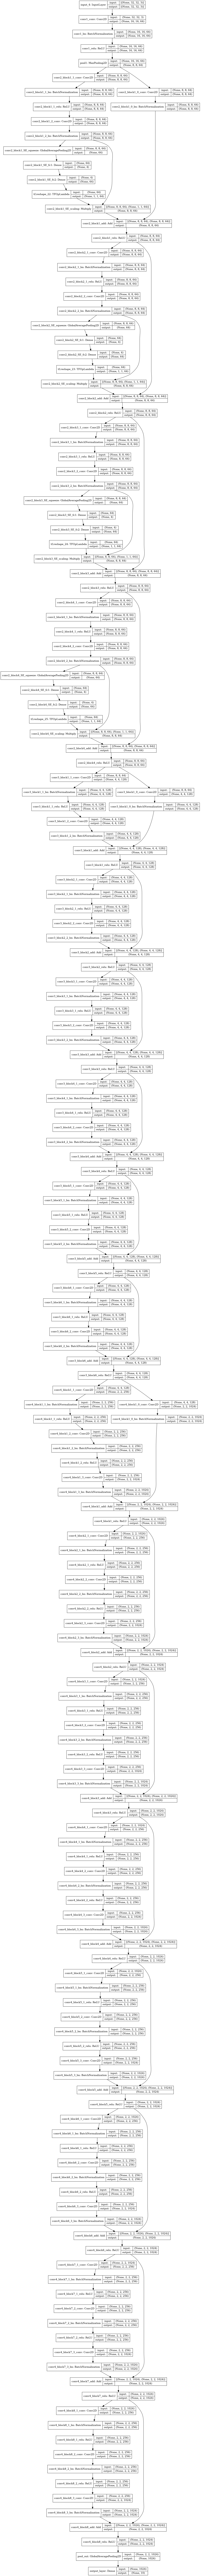

In [21]:
from utils.SE_resnet import SE_custom_stages
stage2=SE_custom_stages(add_after_layers=stage_2,res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=10,ratio=16,model_name='custom_resnet',debug=False)
stage2.summary()
tf.keras.utils.plot_model(stage2, to_file='img/stage_2.png',show_shapes=True)

#### training

In [22]:
path='./models/stage/stage2.hdf5'
history=train(stage2,path)

Epoch 1/200
375/375 [==============================] - 27s 59ms/step - loss: 3.3059 - acc: 0.2211 - val_loss: 1.9593 - val_acc: 0.3975

Epoch 00001: val_acc improved from -inf to 0.39750, saving model to ./models/stage/stage2.hdf5
Epoch 2/200
375/375 [==============================] - 21s 56ms/step - loss: 1.6228 - acc: 0.4277 - val_loss: 1.4765 - val_acc: 0.4660

Epoch 00002: val_acc improved from 0.39750 to 0.46600, saving model to ./models/stage/stage2.hdf5
Epoch 3/200
375/375 [==============================] - 21s 56ms/step - loss: 1.4240 - acc: 0.4936 - val_loss: 1.3216 - val_acc: 0.5155

Epoch 00003: val_acc improved from 0.46600 to 0.51550, saving model to ./models/stage/stage2.hdf5
Epoch 4/200
375/375 [==============================] - 21s 56ms/step - loss: 1.2969 - acc: 0.5385 - val_loss: 5.7024 - val_acc: 0.3945

Epoch 00004: val_acc did not improve from 0.51550
Epoch 5/200
375/375 [==============================] - 21s 57ms/step - loss: 1.2039 - acc: 0.5754 - val_loss: 2.184


Epoch 00040: val_acc improved from 0.80550 to 0.80750, saving model to ./models/stage/stage2.hdf5
Epoch 41/200
375/375 [==============================] - 21s 56ms/step - loss: 0.3127 - acc: 0.8888 - val_loss: 0.6609 - val_acc: 0.8000

Epoch 00041: val_acc did not improve from 0.80750
Epoch 42/200
375/375 [==============================] - 21s 55ms/step - loss: 0.3050 - acc: 0.8945 - val_loss: 0.6599 - val_acc: 0.7915

Epoch 00042: val_acc did not improve from 0.80750
Epoch 43/200
375/375 [==============================] - 21s 56ms/step - loss: 0.2948 - acc: 0.8958 - val_loss: 0.6769 - val_acc: 0.7970

Epoch 00043: val_acc did not improve from 0.80750
Epoch 44/200
375/375 [==============================] - 21s 56ms/step - loss: 0.2932 - acc: 0.8949 - val_loss: 0.6268 - val_acc: 0.8130

Epoch 00044: val_acc improved from 0.80750 to 0.81300, saving model to ./models/stage/stage2.hdf5
Epoch 45/200
375/375 [==============================] - 21s 55ms/step - loss: 0.2884 - acc: 0.8978 - val_

#### Accuracy

In [23]:
model=SE_custom_stages(add_after_layers=stage_2,res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=10,ratio=16,model_name='custom_resnet',debug=False)
model.load_weights(path)
model.save('./full_models/stage/stage2.h5')
del model  # deletes the existing model
model = tf.keras.models.load_model('./full_models/stage/stage2.h5')
score(model,X_test,y_test,top_n=[3,5])

313/313 - 4s - loss: 0.7758 - acc: 0.8135
SE_custom_resnet
model accuracy: 81.35%
top 3 accuracy: 95.77000141143799
top 5 accuracy: 98.64000082015991


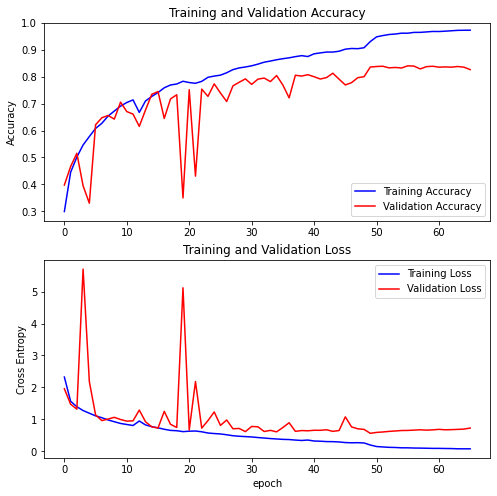

In [24]:
from utils.train_CIFAR_ResNet import plot_model
plot_model(history)

# Stage 3

#### List of layers where the SE block is going to be inserted

In [41]:
stage_3=[l for l in list_se if 'conv3' in l]
stage_3

['conv3_block1_2_bn',
 'conv3_block2_2_bn',
 'conv3_block3_2_bn',
 'conv3_block4_2_bn',
 'conv3_block5_2_bn',
 'conv3_block6_2_bn']

#### Resnet model with only stage 3 SE blocks

Model: "SE_custom_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_13[0][0]                   
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[1][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_bn[1][0]                   
___________________________________________________________________________________

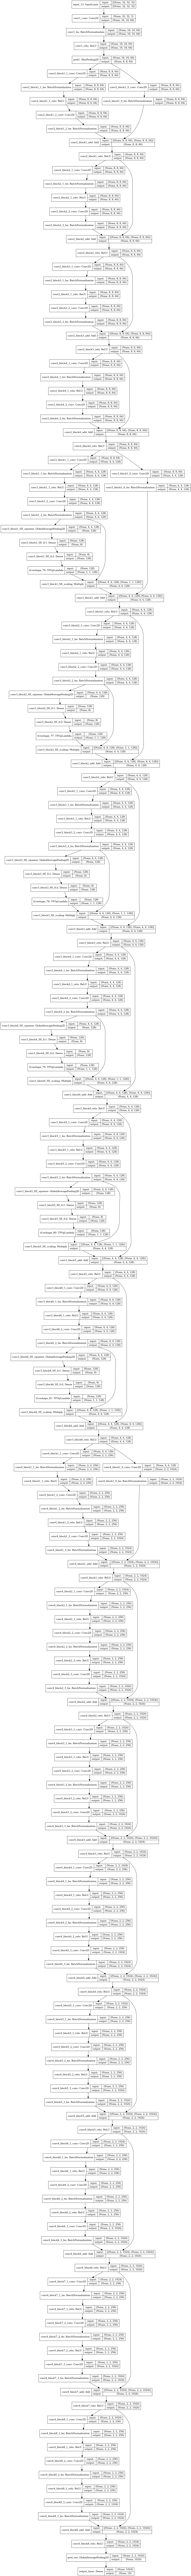

In [44]:
stage3=SE_custom_stages(add_after_layers=stage_3,res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=10,ratio=16,model_name='custom_resnet',debug=False)
stage3.summary()
tf.keras.utils.plot_model(stage3, to_file='img/stage_3.png',show_shapes=True)

In [45]:
path='./models/stage/stage3.hdf5'
history=train(stage3,path)

Epoch 1/200
375/375 [==============================] - 26s 58ms/step - loss: 3.4072 - acc: 0.1818 - val_loss: 1.7840 - val_acc: 0.3680

Epoch 00001: val_acc improved from -inf to 0.36800, saving model to ./models/stage/stage3.hdf5
Epoch 2/200
375/375 [==============================] - 21s 55ms/step - loss: 1.7393 - acc: 0.3732 - val_loss: 1.9629 - val_acc: 0.4020

Epoch 00002: val_acc improved from 0.36800 to 0.40200, saving model to ./models/stage/stage3.hdf5
Epoch 3/200
375/375 [==============================] - 20s 54ms/step - loss: 1.5556 - acc: 0.4411 - val_loss: 1.4687 - val_acc: 0.4675

Epoch 00003: val_acc improved from 0.40200 to 0.46750, saving model to ./models/stage/stage3.hdf5
Epoch 4/200
375/375 [==============================] - 21s 56ms/step - loss: 1.4301 - acc: 0.4871 - val_loss: 1.2799 - val_acc: 0.5440

Epoch 00004: val_acc improved from 0.46750 to 0.54400, saving model to ./models/stage/stage3.hdf5
Epoch 5/200
375/375 [==============================] - 21s 55ms/ste


Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00040: val_acc did not improve from 0.77900
Epoch 41/200
375/375 [==============================] - 20s 54ms/step - loss: 0.2844 - acc: 0.9011 - val_loss: 0.5942 - val_acc: 0.8120

Epoch 00041: val_acc improved from 0.77900 to 0.81200, saving model to ./models/stage/stage3.hdf5
Epoch 42/200
375/375 [==============================] - 21s 55ms/step - loss: 0.2266 - acc: 0.9218 - val_loss: 0.5992 - val_acc: 0.8120

Epoch 00042: val_acc did not improve from 0.81200
Epoch 43/200
375/375 [==============================] - 21s 55ms/step - loss: 0.2061 - acc: 0.9275 - val_loss: 0.6137 - val_acc: 0.8180

Epoch 00043: val_acc improved from 0.81200 to 0.81800, saving model to ./models/stage/stage3.hdf5
Epoch 44/200
375/375 [==============================] - 21s 56ms/step - loss: 0.1927 - acc: 0.9328 - val_loss: 0.6359 - val_acc: 0.8040

Epoch 00044: val_acc did not improve from 0.81800
Epoch 45/200
375/375 [==================

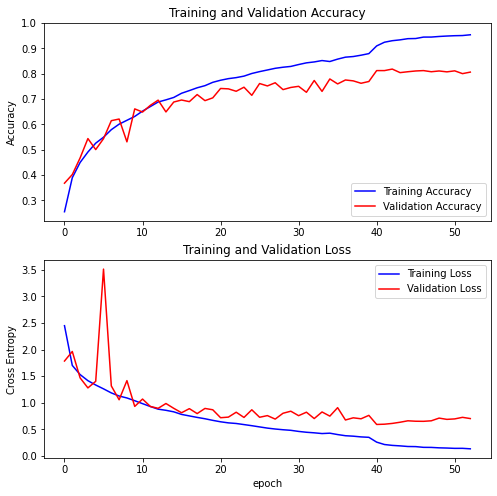

In [46]:
plot_model(history)

#### Accuracy

In [47]:
model=SE_custom_stages(add_after_layers=stage_3,res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=10,ratio=16,model_name='custom_resnet',debug=False)
model.load_weights(path)
model.save('./full_models/stage/stage3.h5')
del model  # deletes the existing model
model = tf.keras.models.load_model('./full_models/stage/stage3.h5')
score(model,X_test,y_test,top_n=[3,5])

313/313 - 4s - loss: 0.6955 - acc: 0.8026
SE_custom_resnet
model accuracy: 80.26%
top 3 accuracy: 95.5299973487854
top 5 accuracy: 98.83000254631042


# Stage 4

#### List of layers where the SE block is going to be inserted

In [31]:
stage_4=[l for l in list_se if 'conv4' in l]
stage_4

['conv4_block1_3_bn',
 'conv4_block2_3_bn',
 'conv4_block3_3_bn',
 'conv4_block4_3_bn',
 'conv4_block5_3_bn',
 'conv4_block6_3_bn',
 'conv4_block7_3_bn',
 'conv4_block8_3_bn']

#### Resnet model with only stage 2 SE blocks

Model: "SE_custom_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_8[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[1][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_bn[1][0]                   
___________________________________________________________________________________

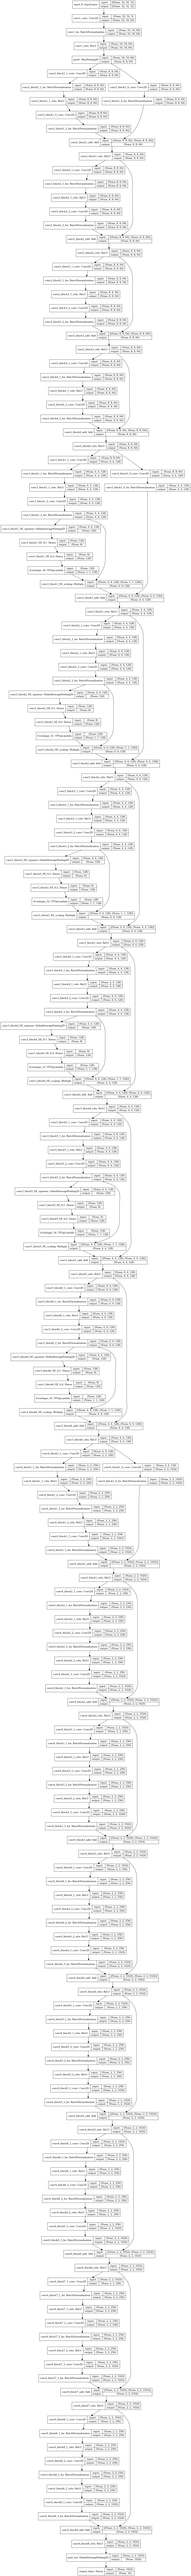

In [32]:
stage4=SE_custom_stages(add_after_layers=stage_4,res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=10,ratio=16,model_name='custom_resnet',debug=False)
stage4.summary()
tf.keras.utils.plot_model(stage3, to_file='img/stage_4.png',show_shapes=True)

In [33]:
path='./models/stage/stage4.hdf5'
history=train(stage4,path)

Epoch 1/200
375/375 [==============================] - 27s 61ms/step - loss: 2.2682 - acc: 0.2750 - val_loss: 1.5247 - val_acc: 0.4450

Epoch 00001: val_acc improved from -inf to 0.44500, saving model to ./models/stage/stage4.hdf5
Epoch 2/200
375/375 [==============================] - 23s 60ms/step - loss: 1.4559 - acc: 0.4772 - val_loss: 1.3129 - val_acc: 0.5250

Epoch 00002: val_acc improved from 0.44500 to 0.52500, saving model to ./models/stage/stage4.hdf5
Epoch 3/200
375/375 [==============================] - 22s 59ms/step - loss: 1.2708 - acc: 0.5467 - val_loss: 1.3479 - val_acc: 0.5245

Epoch 00003: val_acc did not improve from 0.52500
Epoch 4/200
375/375 [==============================] - 22s 59ms/step - loss: 1.1148 - acc: 0.6053 - val_loss: 1.1221 - val_acc: 0.5935

Epoch 00004: val_acc improved from 0.52500 to 0.59350, saving model to ./models/stage/stage4.hdf5
Epoch 5/200
375/375 [==============================] - 23s 60ms/step - loss: 1.0002 - acc: 0.6457 - val_loss: 1.095

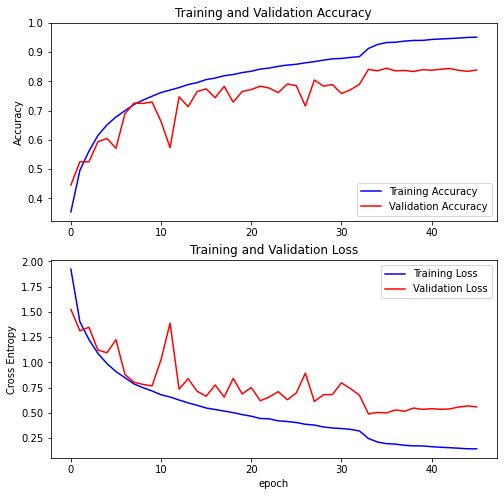

In [34]:
plot_model(history)

#### Accuracy

In [35]:
model=SE_custom_stages(add_after_layers=stage_4,res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=10,ratio=16,model_name='custom_resnet',debug=False)
model.load_weights(path)
model.save('./full_models/stage/stage4.h5')
del model  # deletes the existing model
model = tf.keras.models.load_model('./full_models/stage/stage4.h5')
score(model,X_test,y_test,top_n=[3,5])

313/313 - 4s - loss: 0.5710 - acc: 0.8330
SE_custom_resnet
model accuracy: 83.30%
top 3 accuracy: 96.59000039100647
top 5 accuracy: 98.90999794006348
